In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Télécharger les données

In [21]:
data_frame=pd.read_csv("/home/onyxia/work/NLP_3A_ENSAE/data_bases/data_cleaned.csv",sep=",")

In [22]:
data_frame.head()

,Unnamed: 0,sex,first_name,surname
0,0,femme,Marie,Chardon
1,1,homme,Louis,Lhopital
2,2,femme,Marie,Pyrin
3,3,femme,Marie,Lavocat
4,4,femme,Marguerite,Benne


In [23]:
texts = data_frame['first_name'].tolist()
labels = data_frame['sex'].tolist()


# Télécharger le modèle de Hagging face et manipulation des données pour le fine tuning

In [24]:
model_name = "padmajabfrl/Gender-Classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

## Je split les données en training et testing

In [25]:

train_texts, test_texts, train_labels,test_labels = train_test_split(texts, labels, test_size=.2)



In [26]:
# Je transforme mes données de façon à ce que les femmes soient encodées en 1 et les hommes en 0
label_map = {'homme': 0, 'femme': 1}  
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

Turn the data to Dataset

In [27]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label)
        }

    def __len__(self):
        return len(self.labels)


train_dataset = IMDbDataset(train_texts, train_labels, tokenizer, max_length=128)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer, max_length=128)


In [28]:
class GenderClassifier:
    def __init__(self, model_name='padmajabfrl/Gender-Classification'):
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def train(self, train_dataset, num_epochs=10, batch_size=16, learning_rate=5e-5):
        self.model.to(self.device)
        self.model.train()
        optimizer = torch.optim.AdamW (self.model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            total_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

        self.model.eval()

    def predict(self, input_text):
        inputs = self.tokenizer(input_text, return_tensors='pt')
        inputs = {key: val.to(self.device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        predictions = torch.argmax(outputs.logits, dim=1).item()
        label_map = {0: 'homme', 1: 'femme'}
        predicted_label = label_map[predictions]

        return predicted_label
    
    def evaluate(self,test_dataset, batch_size=16,conf_matrix=False,Roc_curve=False,pr_curve=False):
        self.model.eval()
        all_probs = []
        true_labels = []
        predicted_labels = []
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        for batch in test_loader:
            input_ids = batch['input_ids'].to(classifier.device)
            attention_mask = batch['attention_mask'].to(classifier.device)
            labels = batch['labels']

            with torch.no_grad():
                outputs = classifier.model(input_ids, attention_mask=attention_mask)

            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()


            # Metrics calculation for visualization
            if Roc_curve or pr_curve:
                probs = torch.softmax(outputs.logits, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())
                


            true_labels.extend(labels)
            predicted_labels.extend(predictions)
        true_labels = np.array(true_labels)

        predicted_labels = np.array(predicted_labels)
        accuracy = accuracy_score(true_labels, predicted_labels)
        report = classification_report(true_labels, predicted_labels)
        print(f"The model's accuracy on the testing dataset is: {accuracy}. \n The model's performance report on the testing dataset is the following :\n {report}")

        # Plotting some intersting metrics about the classifier

        #Confucion matrix

        if conf_matrix:
            print("Find bellow the Confusion Matrix")
            conf_matrix = confusion_matrix(true_labels, predicted_labels)
            sns.heatmap(cmatrix,fmt='d',cmap='BuPu',annot=True)
            plt.figure(figsize=(8, 6))
            plt.imshow(conf_matrix, cmap='BuPu', interpolation='nearest')
            plt.colorbar()
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.xticks([0, 1], ['homme', 'femme'])
            plt.yticks([0, 1], ['homme', 'femme'])
            plt.show()
        
        #ROC Curve

        if Roc_curve:
            print("Find bellow the ROC Curve")
            fpr, tpr, _ = roc_curve(true_labels, all_probs)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()

        
        #Precision-Recall Curve

        if pr_curve:
            print("Find bellow the Precision-Recall Curve")
            precision, recall, _ = precision_recall_curve(true_labels, all_probs)
            pr_auc = auc(recall, precision)

            plt.figure()
            plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend(loc="lower left")
            plt.show()


In [19]:
# Training
classifier = GenderClassifier()
classifier.train(train_dataset,num_epochs=15)  # Assuming train_dataset is already defined


Epoch 1/15, Loss: 0.5102
Epoch 2/15, Loss: 0.1904
Epoch 3/15, Loss: 0.1412
Epoch 4/15, Loss: 0.0955
Epoch 5/15, Loss: 0.0841
Epoch 6/15, Loss: 0.0538
Epoch 7/15, Loss: 0.0509
Epoch 8/15, Loss: 0.0407
Epoch 9/15, Loss: 0.0655
Epoch 10/15, Loss: 0.0466
Epoch 11/15, Loss: 0.0441
Epoch 12/15, Loss: 0.0413
Epoch 13/15, Loss: 0.0339
Epoch 14/15, Loss: 0.0352
Epoch 15/15, Loss: 0.0400


In [29]:
# Prediction
prediction = classifier.predict("Francoise")
print(f'Predicted label: {prediction}')

Predicted label: femme


The model's accuracy on the testing dataset is: 0.9787234042553191. 
 The model's performance report on the testing dataset is the following :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.96      1.00      0.98        23

    accuracy                           0.98        47
   macro avg       0.98      0.98      0.98        47
weighted avg       0.98      0.98      0.98        47

Find bellow the Confusion Matrix


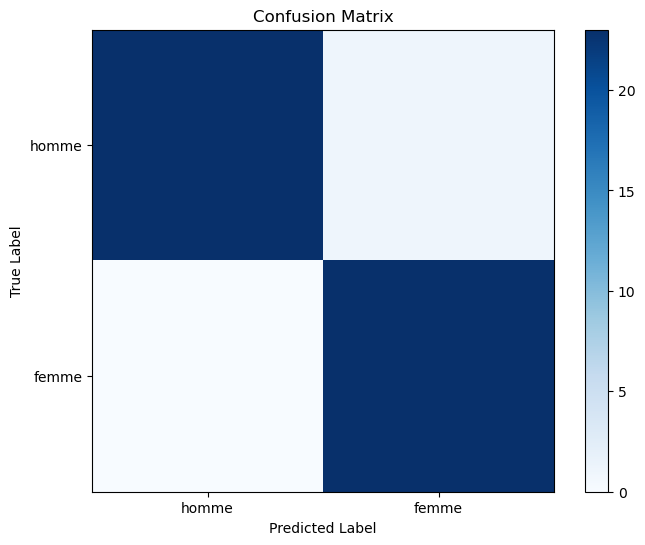

Find bellow the ROC Curve


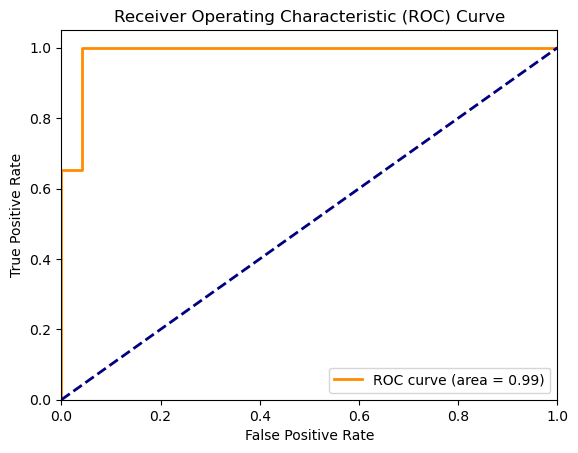

Find bellow the Precision-Recall Curve


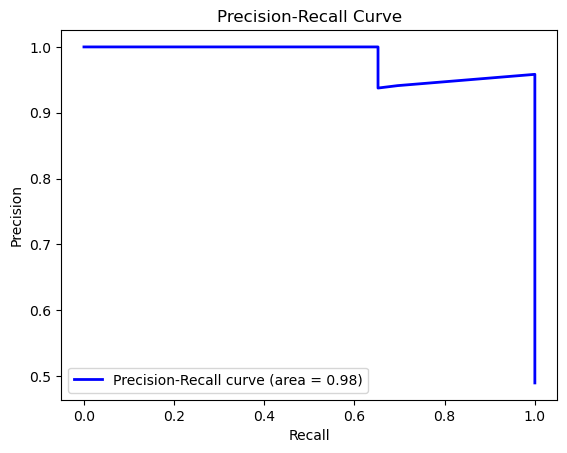

In [17]:
classifier.evaluate(test_dataset,conf_matrix=True,Roc_curve=True,pr_curve=True)